# AI vs real image classification

Getting the dataset

for google colab, I used
```python
from google.colab import files
files.upload()
```
so I could upload my kaggle.json file (legacy kaggle API credentials)
but I deleted the block because the credentials were visible on the output

In [2]:
%pip install -q kaggle

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!mkdir -p /content/datasets
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images -p /content/datasets
!unzip -q /content/datasets/cifake-real-and-ai-generated-synthetic-images.zip -d /content/datasets/cifake
!ls -R /content/datasets/cifake | head -5

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.44GB/s]
/content/datasets/cifake:
test
train

/content/datasets/cifake/test:


## Baseline

Imports and parameters

In [4]:
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, roc_auc_score
import os
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import types
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import glob
import shutil
import random
from tqdm import tqdm

base_dir = "/content/datasets/cifake"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")

def reduce_dataset(root, percent=0.1): # using only 10% since the dataset is too big
    for cls in ["REAL", "FAKE"]:
        folder = os.path.join(root, cls)
        files = glob.glob(folder + "/*")

        keep = int(len(files) * percent)
        files_to_delete = random.sample(files, len(files) - keep)

        for f in files_to_delete:
            os.remove(f)

reduce_dataset(train_dir, percent=0.10)
reduce_dataset(val_dir,  percent=0.10)

img_size = (224, 224)
batch_size = 64
seed = 67

Datasets and prefetch

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 60000 files belonging to 2 classes.
Found 12000 files belonging to 2 classes.


Model

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_size + (3,),
    pooling="avg"
)
base_model.trainable = False

inputs = tf.keras.Input(shape=img_size + (3,))
x = preprocess_input(inputs)
x = base_model(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

Training + eval

In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

eval_results = model.evaluate(val_ds)
print("loss:", eval_results[0])
print("accuracy:", eval_results[1])
print("AUC:", eval_results[2])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 182ms/step - accuracy: 0.5911 - auc: 0.6298 - loss: 0.7509 - val_accuracy: 0.7675 - val_auc: 0.8534 - val_loss: 0.4845
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.7721 - auc: 0.8520 - loss: 0.4783 - val_accuracy: 0.8350 - val_auc: 0.9142 - val_loss: 0.3898
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step - accuracy: 0.8225 - auc: 0.9020 - loss: 0.4014 - val_accuracy: 0.8640 - val_auc: 0.9359 - val_loss: 0.3423
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.8492 - auc: 0.9261 - loss: 0.3534 - val_accuracy: 0.8770 - val_auc: 0.9469 - val_loss: 0.3128
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.8622 - auc: 0.9400 - loss: 0.3212 - val_accuracy: 0.8880 - val_auc: 0.9538 - val_loss: 0.2921
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 99ms/step - accuracy: 0.8798 - auc: 0.9472 - loss: 0.3024 - val_accuracy: 0.8935 - val_auc: 0.9589 - val_loss: 0.2758
Epoch 7/10
313/313 ━━━━━

<Figure size 600x500 with 0 Axes>

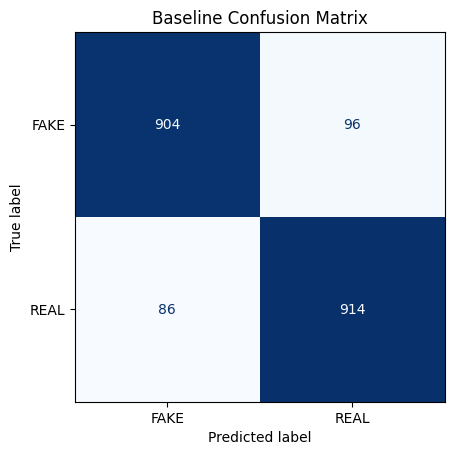

In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_true.extend(labels.numpy().flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["FAKE", "REAL"])

plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', colorbar=False)
plt.title("Baseline Confusion Matrix")
plt.show()

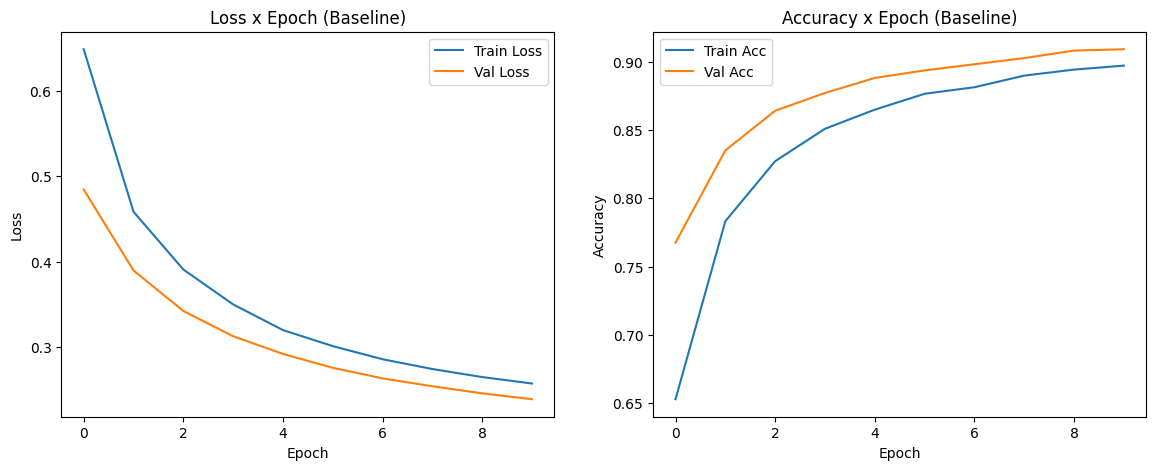

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss x Epoch (Baseline)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy x Epoch (Baseline)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

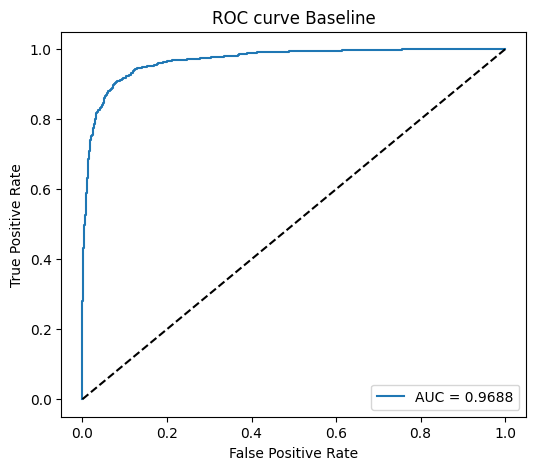

In [ ]:
y_true = []
y_score = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_score.extend(preds.flatten())
    y_true.extend(labels.numpy().flatten())

y_true = np.array(y_true)
y_score = np.array(y_score)

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve Baseline")
plt.legend()
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=["FAKE", "REAL"]))

              precision    recall  f1-score   support

        FAKE       0.91      0.90      0.91      1000
        REAL       0.90      0.91      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



## 1st enhancement

### High-pass filter for synthetic noise extraction

In [6]:
noise_train_dir = "/content/datasets/cifake_noise/train"
noise_val_dir = "/content/datasets/cifake_noise/test"

os.makedirs(noise_train_dir, exist_ok=True)
os.makedirs(noise_val_dir, exist_ok=True)

In [7]:
def residual_noise(x):
    # convert to grayscale
    x = tf.image.rgb_to_grayscale(x)
    x = tf.expand_dims(x, axis=0)

    # srm convolution kernels
    k1 = tf.constant([  # horizontal border detection
        [0, 0, 0],
        [0,-1, 1],
        [0, 1, 0]
    ], dtype=tf.float32)

    k2 = tf.constant([  # 'aggressive' laplacian filter
        [-1, 2, -1],
        [2, -4, 2],
        [-1, 2, -1]
    ], dtype=tf.float32)

    k3 = tf.constant([ # detect vertical borders and amplify noise
        [0, 1, 0],
        [1,-4, 1],
        [0, 1, 0]
    ], dtype=tf.float32)

    # reshape kernels (h, w, in, out)
    k1 = tf.reshape(k1, [3,3,1,1])
    k2 = tf.reshape(k2, [3,3,1,1])
    k3 = tf.reshape(k3, [3,3,1,1])

    # apply the filters
    f1 = tf.nn.conv2d(x, k1, strides=[1,1,1,1], padding="SAME")
    f2 = tf.nn.conv2d(x, k2, strides=[1,1,1,1], padding="SAME")
    f3 = tf.nn.conv2d(x, k3, strides=[1,1,1,1], padding="SAME")

    # stack as channels
    noise = tf.concat([f1, f2, f3], axis=-1)

    noise = tf.squeeze(noise, axis=0)
    return noise

In [8]:
@tf.function
def write_noise(path, dst_root):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [224,224])

    # compute high-pass residual noise
    noise = residual_noise(img)

    # normalizing it
    noise = tf.clip_by_value(noise, -255, 255)
    noise = tf.cast(noise - tf.reduce_min(noise), tf.uint8)

    # build output path (same class and filename as original)
    fname = tf.strings.split(path, "/")[-1]
    fname_noext = tf.strings.regex_replace(fname, r"\.[^.]+$", "")
    cls = tf.strings.split(path, "/")[-2]

    out_path = tf.strings.join([dst_root, "/", cls, "/", fname_noext, ".png"])
    png = tf.io.encode_png(noise) # noise map as png :D
    tf.io.write_file(out_path, png)
    return 0

def build_noise_dataset(src_dir, dst_dir):
    for cls in ["REAL", "FAKE"]:
        os.makedirs(os.path.join(dst_dir, cls), exist_ok=True)

    files = tf.data.Dataset.list_files(src_dir + "/*/*", shuffle=False)
    ds = files.map(lambda p: write_noise(p, dst_dir),
                   num_parallel_calls=64)
    return ds

ds_train = build_noise_dataset("/content/datasets/cifake/train", noise_train_dir)
ds_test = build_noise_dataset("/content/datasets/cifake/test", noise_val_dir)

train_count = len(tf.io.gfile.glob("/content/datasets/cifake/train/*/*"))
test_count  = len(tf.io.gfile.glob("/content/datasets/cifake/test/*/*"))

print("noise maps (train)...")
for _ in tqdm(ds_train, total=train_count, desc="train noise"):
    pass

print("noise maps (test)...")
for _ in tqdm(ds_test, total=test_count, desc="test noise"):
    pass

noise maps (train)...


train noise: 100%|██████████| 60000/60000 [05:35<00:00, 178.63it/s]


noise maps (test)...


test noise: 100%|██████████| 12000/12000 [01:04<00:00, 184.92it/s]


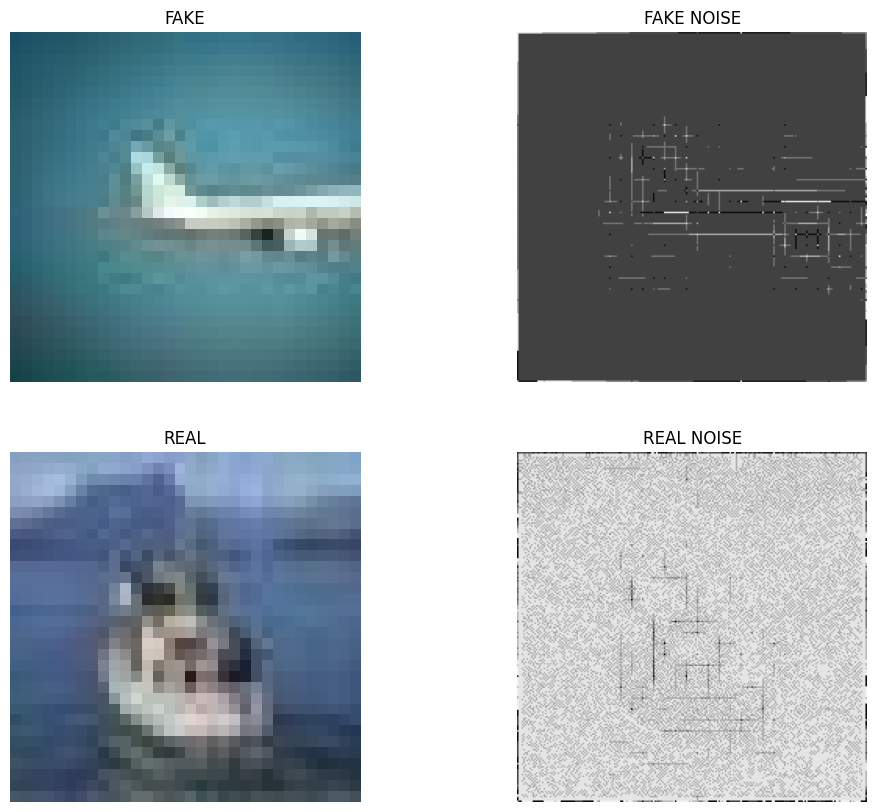

In [41]:
fake_imgs = glob.glob(train_dir + "/FAKE/*.jpg")
real_imgs = glob.glob(train_dir + "/REAL/*.jpg")

fake_path = random.choice(fake_imgs)
real_path = random.choice(real_imgs)

fake_noise_path = fake_path.replace("/content/datasets/cifake/train", noise_train_dir).replace(".jpg", ".png")
real_noise_path = real_path.replace("/content/datasets/cifake/train", noise_train_dir).replace(".jpg", ".png")

img_fake = Image.open(fake_path)
img_real = Image.open(real_path)

img_fake_noise = Image.open(fake_noise_path).convert("L")
img_real_noise = Image.open(real_noise_path).convert("L")

img_fake_noise = np.array(img_fake_noise) * 50
img_fake_noise = np.clip(img_fake_noise, 0, 255).astype(np.uint8)

img_real_noise = np.array(img_real_noise) * 50
img_real_noise = np.clip(img_real_noise, 0, 255).astype(np.uint8)

plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.imshow(img_fake)
plt.title("FAKE")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(img_fake_noise, cmap="gray")
plt.title("FAKE NOISE")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(img_real)
plt.title("REAL")
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(img_real_noise, cmap="gray")
plt.title("REAL NOISE")
plt.axis("off")

plt.show()

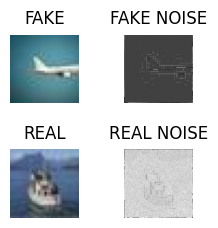

In [45]:
plt.figure(figsize=(2.5, 2.5))

plt.subplot(2,2,1)
plt.imshow(img_fake)
plt.title("FAKE", pad=8)
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(img_fake_noise, cmap="gray")
plt.title("FAKE NOISE", pad=8)
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(img_real)
plt.title("REAL", pad=8)
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(img_real_noise, cmap="gray")
plt.title("REAL NOISE", pad=8)
plt.axis("off")

plt.tight_layout(pad=1.5)
plt.show()

### Pre-processing

In [ ]:
def augment_pair(img, noise):
    # flip horizontal
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        noise = tf.image.flip_left_right(noise)

    # small rotation
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k=k)
    noise = tf.image.rot90(noise, k=k)

    # random zoom crop
    crop = tf.image.resize_with_crop_or_pad(img, 200, 200)
    crop_noise = tf.image.resize_with_crop_or_pad(noise, 200, 200)

    img = tf.image.resize(crop, [224, 224])
    noise = tf.image.resize(crop_noise, [224, 224])

    img = tf.image.random_contrast(img, 0.8, 1.2)

    return img, noise

In [ ]:
def load_pair(path):
    fname = tf.strings.split(path, "/")[-1]
    cls = tf.strings.split(path, "/")[-2]

    label = tf.where(cls == "REAL", 1, 0)

    is_train = tf.strings.regex_full_match(path, ".*cifake/train/.*")
    base_dir = tf.where(is_train, noise_train_dir, noise_val_dir)

    fname_noext = tf.strings.regex_replace(fname, r"\.[^.]+$", "")
    noise_path = tf.strings.join([base_dir, "/", cls, "/", fname_noext, ".png"])

    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [224,224])
    img = tf.keras.applications.resnet50.preprocess_input(img)

    # load and resize precomputed noise map
    noise = tf.io.read_file(noise_path)
    noise = tf.image.decode_png(noise, channels=1)
    noise = tf.image.resize(noise, [224,224])

    return (img, noise), label

def extract_label(path):
    # 1 if REAL in filepath, else 0
    label = tf.strings.regex_full_match(path, ".*REAL.*")
    return tf.cast(label, tf.int32)


train_paths = tf.data.Dataset.list_files("/content/datasets/cifake/train/*/*", shuffle=True)
val_paths = tf.data.Dataset.list_files("/content/datasets/cifake/test/*/*", shuffle=False)

train_labels = train_paths.map(extract_label, num_parallel_calls=tf.data.AUTOTUNE)
val_labels = val_paths.map(extract_label, num_parallel_calls=tf.data.AUTOTUNE)

# dataset returning (img, noise) pairs
train_ds_enh1 = (
    tf.data.Dataset.list_files("/content/datasets/cifake/train/*/*", shuffle=True)
    .map(load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_enh1 = (
    tf.data.Dataset.list_files("/content/datasets/cifake/test/*/*", shuffle=False)
    .map(load_pair, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# apply augmentation
train_ds_enh1_aug = train_ds_enh1.map(
    lambda inputs, label: (augment_pair(inputs[0], inputs[1]), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

### Dual-branch model construction (RGB stream + noise stream)

In [ ]:
base_model_enh1 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=img_size + (3,),
    pooling="avg"
)
base_model_enh1.trainable = False # freeze backbone for stable training and to avoid destroying pretrained features

noise_input = tf.keras.Input(shape=(224,224,1))
n = tf.keras.layers.Rescaling(1./255)(noise_input) # normalize noise
n = tf.keras.layers.Conv2D(16, 3, activation="relu")(n)
n = tf.keras.layers.MaxPooling2D()(n)
n = tf.keras.layers.Conv2D(32, 3, activation="relu")(n)
n = tf.keras.layers.MaxPooling2D()(n)
n = tf.keras.layers.Conv2D(64, 3, activation="relu")(n)
n = tf.keras.layers.Conv2D(128, 3, activation="relu")(n)
n = tf.keras.layers.GlobalAveragePooling2D()(n)
n = tf.keras.layers.Dense(256, activation="relu")(n)

img_input = tf.keras.Input(shape=(224,224,3)) # image branch (pretrained backbone)
x = base_model_enh1(img_input)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)

combined = tf.keras.layers.concatenate([x, n]) # fuse image and noise feature vectors
# classification head
combined = tf.keras.layers.Dense(128, activation="relu")(combined)
combined = tf.keras.layers.Dropout(0.1)(combined)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(combined)

model_enh1 = tf.keras.Model(inputs=[img_input, noise_input], outputs=outputs) # dual-input model (rgb + noise)

# compile for initial training with frozen backbone
model_enh1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)


In [ ]:
# unfreeze only the top ResNet layers for fine-tuning
for layer in base_model_enh1.layers[:-80]:
    layer.trainable = False

for layer in base_model_enh1.layers[-80:]:
    layer.trainable = True

model_enh1.compile( # re-compile with lower learning rate for stable fine-tuning
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

In [ ]:
callbacks_enh1 = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc",
        patience=3,
        mode="max",
        restore_best_weights=True
    )
]

history_enh1 = model_enh1.fit(
    train_ds_enh1_aug,
    epochs=10,
    callbacks=callbacks_enh1,
    validation_data=val_ds_enh1
)

eval_results = model_enh1.evaluate(val_ds_enh1)
print("loss:", eval_results[0])
print("accuracy:", eval_results[1])
print("AUC:", eval_results[2])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 136ms/step - accuracy: 0.6800 - auc: 0.7510 - loss: 0.5827 - val_accuracy: 0.8560 - val_auc: 0.9565 - val_loss: 0.3322
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.8888 - auc: 0.9584 - loss: 0.2677 - val_accuracy: 0.8995 - val_auc: 0.9770 - val_loss: 0.2445
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.9223 - auc: 0.9745 - loss: 0.2038 - val_accuracy: 0.8890 - val_auc: 0.9821 - val_loss: 0.2622
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.9437 - auc: 0.9868 - loss: 0.1486 - val_accuracy: 0.8990 - val_auc: 0.9849 - val_loss: 0.2444
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9473 - auc: 0.9888 - loss: 0.1372 - val_accuracy: 0.9095 - val_auc: 0.9859 - val_loss: 0.2353
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9512 - auc: 0.9920 - loss: 0.1170 - val_accuracy: 0.9260 - val_auc: 0.9880 - val_loss: 0.1932
Epoch 7/10
313/313 ━━━━━━━━

<Figure size 600x500 with 0 Axes>

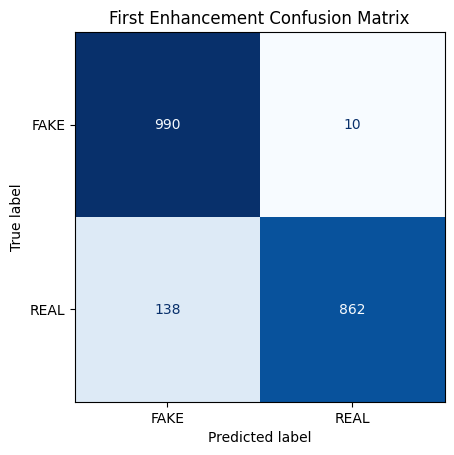

In [ ]:
y_true = []
y_pred = []

for (img, noise, fft), label in val_ds_enh1:
    preds = model_enh1.predict((img, noise), verbose=0)
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_true.extend(label.numpy().flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["FAKE", "REAL"])

plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', colorbar=False)
plt.title("First Enhancement Confusion Matrix")
plt.show()

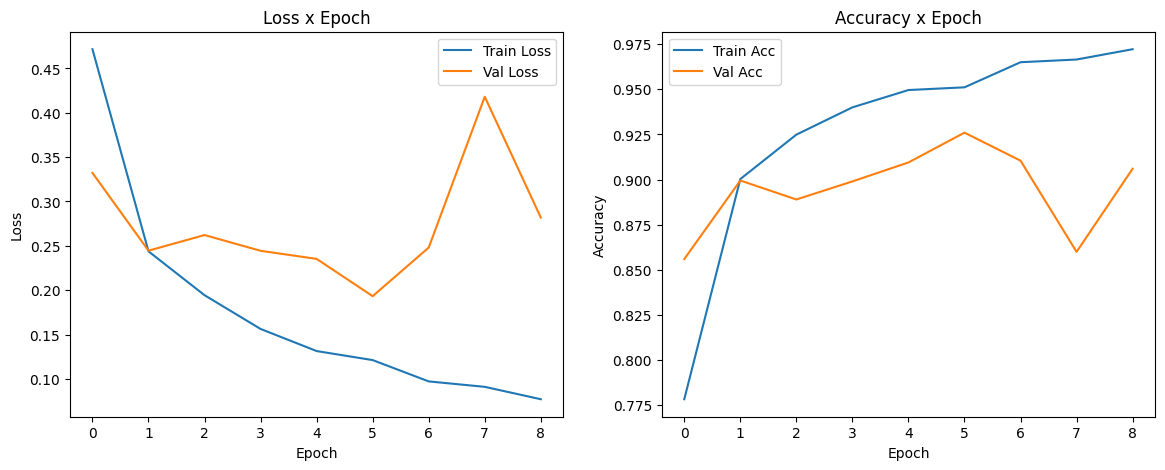

In [ ]:
history = history_enh1

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss x Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy x Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

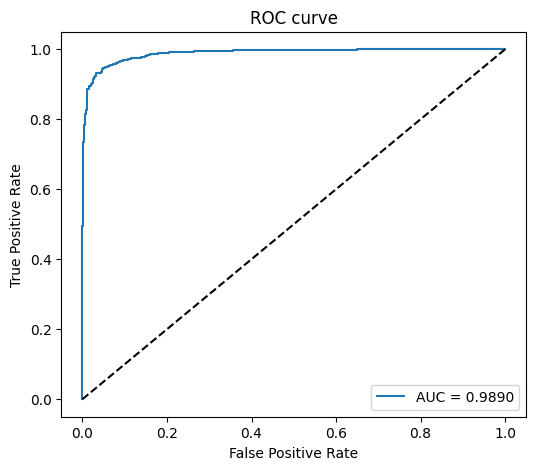

In [ ]:
y_true = []
y_score = []

for (img, noise, fft), label in val_ds_enh1:
    preds = model_enh1.predict((img, noise), verbose=0)
    y_score.extend(preds.flatten())
    y_true.extend(label.numpy().flatten())

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()


In [ ]:
print(classification_report(y_true, y_pred, target_names=["FAKE", "REAL"]))

              precision    recall  f1-score   support

        FAKE       0.88      0.99      0.93      1000
        REAL       0.99      0.86      0.92      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



## 2nd enhancement

#### Convolutional Block Attention Module (CBAM)

Channel Attention

In [9]:
class Channel_Attention(nn.Module):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max']):
        super(Channel_Attention, self).__init__()
        self.pool_types = pool_types

        self.shared_mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channel_in, channel_in // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(channel_in // reduction_ratio, channel_in)
        )

    def forward(self, x, noise):
        noise_resized = torch.nn.functional.interpolate(
            noise, size=(x.size(2), x.size(3)), mode="bilinear", align_corners=False
        )

        channel_attentions = []

        for pool_type in self.pool_types:
            if pool_type == 'avg':
                pool = torch.mean(x, dim=(2,3), keepdim=True)
                noise_avg = torch.mean(noise_resized, dim=(2,3), keepdim=True)
                pool = pool + noise_avg

            elif pool_type == 'max':
                pool = torch.amax(x, dim=(2,3), keepdim=True)
                noise_max = torch.amax(noise_resized, dim=(2,3), keepdim=True)
                pool = pool + noise_max

            pool = pool.view(pool.size(0), -1)
            channel_attentions.append(self.shared_mlp(pool))

        pooling_sums = torch.stack(channel_attentions, dim=0).sum(dim=0)
        scaled = torch.sigmoid(pooling_sums).unsqueeze(2).unsqueeze(3).expand_as(x)

        return x * scaled

Spatial Attention

In [10]:
class ChannelPool(nn.Module):
    def forward(self, x):
        max_pool = torch.max(x, 1)[0].unsqueeze(1)
        mean_pool = torch.mean(x, 1).unsqueeze(1)
        return torch.cat((max_pool, mean_pool), dim=1)

class Spatial_Attention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2

        self.compress = ChannelPool()
        self.noise_norm = nn.BatchNorm2d(1)

        self.spatial_attention = nn.Sequential(
            nn.Conv2d(3, 1, kernel_size, padding=padding, bias=False),
            nn.BatchNorm2d(1)
        )

    def forward(self, x, noise):
        noise_resized = nn.functional.interpolate(
            noise, size=(x.size(2), x.size(3)),
            mode="bilinear", align_corners=False
        )

        noise_resized = self.noise_norm(noise_resized)

        noise_resized = nn.functional.avg_pool2d(noise_resized, kernel_size=3, stride=1, padding=1)

        x_compress = self.compress(x)

        fusion = torch.cat([x_compress, noise_resized * 0.3], dim=1)

        x_out = self.spatial_attention(fusion)
        scaled = torch.sigmoid(x_out)

        return x * scaled

In [11]:
class CBAM(nn.Module):
    def __init__(self, channel_in, reduction_ratio=16, pool_types=['avg', 'max'], spatial=True):
        super(CBAM, self).__init__()
        self.spatial = spatial
        self.channel_attention = Channel_Attention(channel_in, reduction_ratio, pool_types)

        if spatial:
            self.spatial_attention = Spatial_Attention()

    def forward(self, x, noise):
      x_out = self.channel_attention(x, noise)

      if self.spatial:
          x_out = self.spatial_attention(x_out, noise)

      return x_out

Integration

In [12]:
def resnet50_cbam():
    model = models.resnet50(weights="IMAGENET1K_V1")

    model.layer1_cbam = CBAM(256)
    model.layer2_cbam = CBAM(512)
    model.layer3_cbam = CBAM(1024)
    model.layer4_cbam = CBAM(2048)

    def forward(model_self, x, noise):
        noise_s1 = torch.nn.functional.interpolate(noise, size=(112,112), mode="bilinear", align_corners=False)

        x = model_self.conv1(x)
        x = model_self.bn1(x)
        x = model_self.relu(x)
        x = model_self.maxpool(x)

        noise_s2 = torch.nn.functional.interpolate(noise_s1, size=(56,56), mode="bilinear", align_corners=False)
        x = model_self.layer1(x)
        x = model_self.layer1_cbam(x, noise_s2)

        noise_s3 = torch.nn.functional.interpolate(noise_s2, size=(28,28), mode="bilinear", align_corners=False)
        x = model_self.layer2(x)
        x = model_self.layer2_cbam(x, noise_s3)

        noise_s4 = torch.nn.functional.interpolate(noise_s3, size=(14,14), mode="bilinear", align_corners=False)
        x = model_self.layer3(x)
        x = model_self.layer3_cbam(x, noise_s4)

        noise_s5 = torch.nn.functional.interpolate(noise_s4, size=(7,7), mode="bilinear", align_corners=False)
        x = model_self.layer4(x)
        x = model_self.layer4_cbam(x, noise_s5)

        x = model_self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

    model.forward = types.MethodType(forward, model)
    return model

In [13]:
class FullModel(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone

        self.fft_branch = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.fc = nn.Linear(2048 + 32, 2)

    def forward(self, img, noise, fft):
        feat_img_noise = self.backbone(img, noise)

        fft_feat = self.fft_branch(fft)
        fft_feat = fft_feat.view(fft_feat.size(0), -1)

        fused = torch.cat([feat_img_noise, fft_feat], dim=1)

        return self.fc(fused)

In [14]:
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone = resnet50_cbam()
model = FullModel(backbone).to(device)

for name, param in model.named_parameters():
    if name.startswith("backbone.conv1") or name.startswith("backbone.bn1") or name.startswith("backbone.layer1"):
        param.requires_grad = False
    else:
        param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


AUX

In [15]:
def accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return (preds == labels).float().mean().item()

def compute_auc(all_labels, all_scores):
    try:
        return roc_auc_score(all_labels, all_scores)
    except:
        return 0.0

Training

In [16]:
class ImageNoiseDataset(Dataset):
    def __init__(self, img_root, noise_root):
        self.img_paths = glob.glob(img_root + "/**/*", recursive=True)
        self.img_paths = [p for p in self.img_paths
                          if p.lower().endswith((".jpg",".jpeg",".png"))]

        self.noise_root = noise_root

        self.transform_img = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], # normalizing using default mean and std from imagenet https://github.com/facebookarchive/fb.resnet.torch/blob/master/datasets/imagenet.lua
                        std=[0.229, 0.224, 0.225])
        ])

        self.transform_noise = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.img_paths)

    @staticmethod
    def compute_fft(image_np):
        gray = np.mean(image_np, axis=2)
        f = np.fft.fft2(gray)
        fshift = np.fft.fftshift(f)
        magnitude = np.abs(fshift)
        magnitude = magnitude / (np.max(magnitude) + 1e-8)
        return magnitude.astype(np.float32)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        cls = "REAL" if "REAL" in img_path.upper() else "FAKE"
        fname = os.path.splitext(os.path.basename(img_path))[0] + ".png"
        noise_path = os.path.join(self.noise_root, cls, fname)

        img_pil = Image.open(img_path).convert("RGB")
        noise_pil = Image.open(noise_path).convert("L")

        img_np = np.array(img_pil)
        fft_mag = self.compute_fft(img_np)
        fft_mag = Image.fromarray((fft_mag * 255).astype(np.uint8))

        img = self.transform_img(img_pil)
        noise = self.transform_noise(noise_pil)
        fft_tensor = self.transform_noise(fft_mag)

        label = 1 if cls == "REAL" else 0

        return (img, noise, fft_tensor), label

In [17]:
train_dataset = ImageNoiseDataset(
    "/content/datasets/cifake/train",
    "/content/datasets/cifake_noise/train"
)

val_dataset = ImageNoiseDataset(
    "/content/datasets/cifake/test",
    "/content/datasets/cifake_noise/test"
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [18]:
num_epochs = 10

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "val_auc": []
}

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=num_epochs,
    eta_min=1e-6
)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    train_batches = 0

    for (img, noise, fft), labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} — Training"):
        img = img.to(device)
        noise = noise.to(device)
        fft = fft.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(img, noise, fft)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(outputs, labels)
        train_batches += 1

    train_loss /= train_batches
    train_acc /= train_batches

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_batches = 0

    all_scores = []
    all_labels = []

    with torch.no_grad():
        for (img, noise, fft), labels in tqdm(val_loader, desc="Validating"):
            img = img.to(device)
            noise = noise.to(device)
            labels = labels.to(device)
            fft = fft.to(device)

            outputs = model(img, noise, fft)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += accuracy(outputs, labels)
            val_batches += 1

            scores = torch.softmax(outputs, dim=1)[:, 1]
            all_scores.extend(scores.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= val_batches
    val_acc /= val_batches
    val_auc = compute_auc(all_labels, all_scores)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_auc"].append(val_auc)

    scheduler.step()

    print(
        f"epoch {epoch+1}/{num_epochs} | "
        f"train loss: {train_loss:.4f} | train accuracy: {train_acc:.4f} | "
        f"val loss: {val_loss:.4f} | val accuracy: {val_acc:.4f} | val auc: {val_auc:.4f}"
    )

Validating: 100%|██████████| 188/188 [01:20<00:00,  2.32it/s]


epoch 1/10 | train loss: 0.1403 | train accuracy: 0.9450 | val loss: 0.0936 | val accuracy: 0.9639 | val auc: 0.9950


Validating: 100%|██████████| 188/188 [01:22<00:00,  2.29it/s]


epoch 2/10 | train loss: 0.0711 | train accuracy: 0.9732 | val loss: 0.0768 | val accuracy: 0.9715 | val auc: 0.9963


Validating: 100%|██████████| 188/188 [01:21<00:00,  2.30it/s]


epoch 3/10 | train loss: 0.0446 | train accuracy: 0.9834 | val loss: 0.0743 | val accuracy: 0.9751 | val auc: 0.9966


Validating: 100%|██████████| 188/188 [01:20<00:00,  2.32it/s]


epoch 4/10 | train loss: 0.0263 | train accuracy: 0.9905 | val loss: 0.1019 | val accuracy: 0.9680 | val auc: 0.9964


Validating: 100%|██████████| 188/188 [01:20<00:00,  2.34it/s]


epoch 5/10 | train loss: 0.0151 | train accuracy: 0.9944 | val loss: 0.1047 | val accuracy: 0.9722 | val auc: 0.9960


Validating: 100%|██████████| 188/188 [01:20<00:00,  2.32it/s]


epoch 6/10 | train loss: 0.0076 | train accuracy: 0.9976 | val loss: 0.0850 | val accuracy: 0.9772 | val auc: 0.9973


Validating: 100%|██████████| 188/188 [01:20<00:00,  2.33it/s]


epoch 7/10 | train loss: 0.0029 | train accuracy: 0.9991 | val loss: 0.0893 | val accuracy: 0.9787 | val auc: 0.9974


Validating: 100%|██████████| 188/188 [01:20<00:00,  2.34it/s]


epoch 8/10 | train loss: 0.0016 | train accuracy: 0.9996 | val loss: 0.1065 | val accuracy: 0.9749 | val auc: 0.9976


Validating: 100%|██████████| 188/188 [01:20<00:00,  2.35it/s]


epoch 9/10 | train loss: 0.0007 | train accuracy: 0.9999 | val loss: 0.0872 | val accuracy: 0.9786 | val auc: 0.9978


Validating: 100%|██████████| 188/188 [01:20<00:00,  2.33it/s]

epoch 10/10 | train loss: 0.0002 | train accuracy: 1.0000 | val loss: 0.0842 | val accuracy: 0.9797 | val auc: 0.9979


#### Results

Confusion matrix

<Figure size 600x500 with 0 Axes>

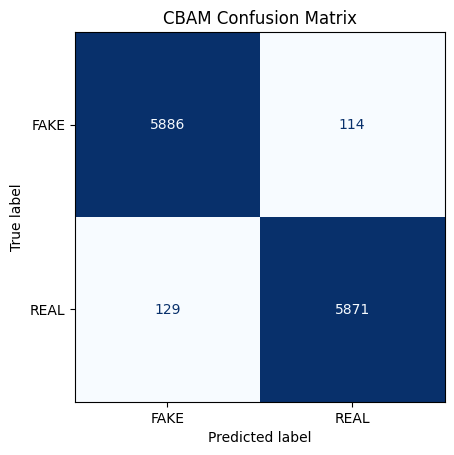

In [19]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for (img, noise, fft), labels in val_loader:
        img = img.to(device)
        noise = noise.to(device)
        fft = fft.to(device)

        outputs = model(img, noise, fft)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["FAKE", "REAL"])

plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", colorbar=False)
plt.title("CBAM Confusion Matrix")
plt.show()

Loss and accuracy

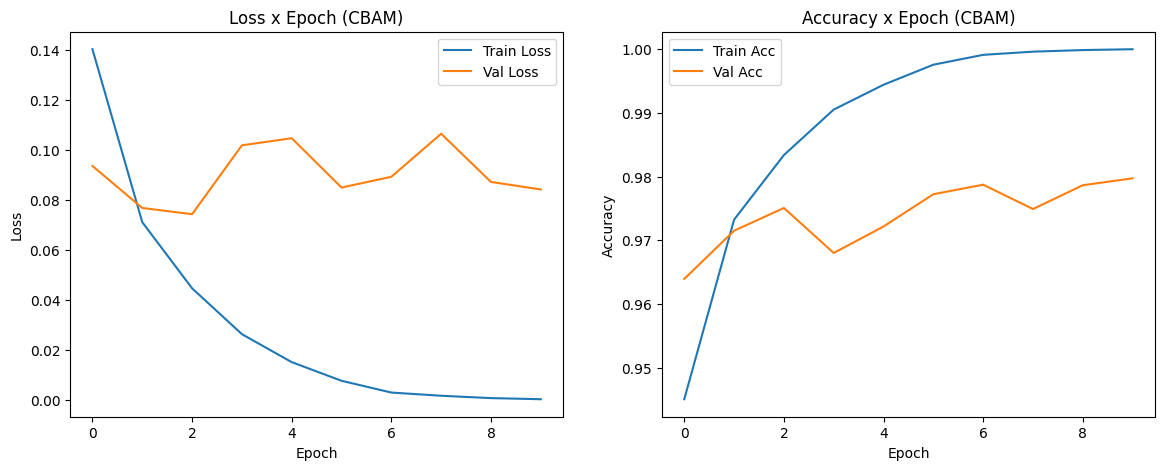

In [20]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss x Epoch (CBAM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy x Epoch (CBAM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


ROC curve

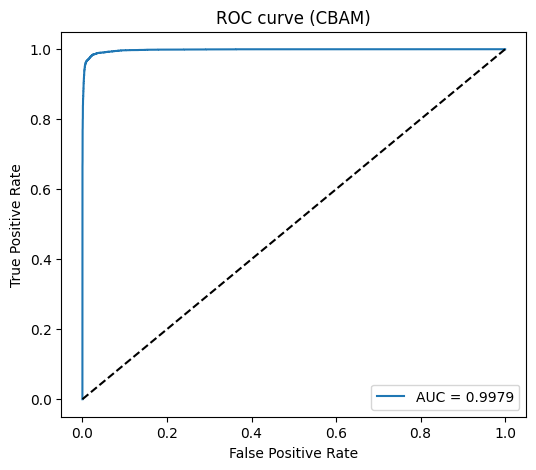

In [21]:
y_true = []
y_score = []

model.eval()
with torch.no_grad():
    for (img, noise, fft), labels in val_loader:
        img = img.to(device)
        noise = noise.to(device)
        fft = fft.to(device)

        outputs = model(img, noise, fft)
        scores = torch.softmax(outputs, dim=1)[:,1]

        y_score.extend(scores.cpu().numpy())
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (CBAM)")
plt.legend()
plt.show()

In [22]:
print(classification_report(y_true, y_pred, target_names=["FAKE", "REAL"]))

              precision    recall  f1-score   support

        FAKE       0.98      0.98      0.98      6000
        REAL       0.98      0.98      0.98      6000

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



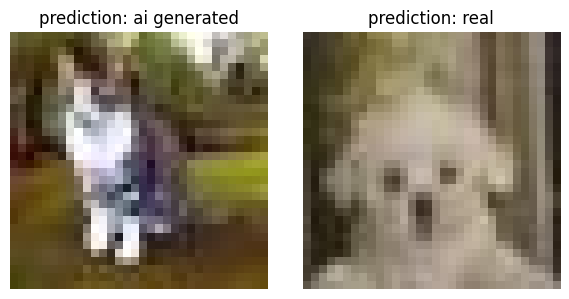

In [57]:
noise_root = "/content/datasets/cifake_noise"

transform_img = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

transform_noise_fft = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])

def compute_fft(img_pil):
    arr = np.array(img_pil)
    gray = np.mean(arr, axis=2).astype(np.float32)

    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    mag /= (mag.max() + 1e-8)

    return Image.fromarray((mag * 255).astype(np.uint8))


def load_sample(img_path):
    img_pil = Image.open(img_path).convert("RGB")

    cls = "REAL" if "REAL" in img_path.upper() else "FAKE"
    fname = os.path.basename(img_path).replace(".jpg", ".png").replace(".jpeg", ".png")

    split = "train" if "/train/" in img_path else "test"
    noise_path = os.path.join(noise_root, split, cls, fname)

    noise_pil = Image.open(noise_path).convert("L")

    fft_pil = compute_fft(img_pil)

    img_t  = transform_img(img_pil).unsqueeze(0).to(device)
    noise_t = transform_noise_fft(noise_pil).unsqueeze(0).to(device)
    fft_t   = transform_noise_fft(fft_pil).unsqueeze(0).to(device)

    return img_pil, img_t, noise_t, fft_t


real_candidates = [p for p in train_dataset.img_paths if "/REAL/" in p]
fake_candidates = [p for p in train_dataset.img_paths if "/FAKE/" in p]

real_path = random.choice(real_candidates)
fake_path = random.choice(fake_candidates)

real_img_pil, real_img_t, real_noise_t, real_fft_t = load_sample(real_path)
fake_img_pil, fake_img_t, fake_noise_t, fake_fft_t = load_sample(fake_path)


model.eval()
with torch.no_grad():
    pred_real = model(real_img_t, real_noise_t, real_fft_t)
    pred_fake = model(fake_img_t, fake_noise_t, fake_fft_t)

cls_real = "real" if torch.argmax(pred_real, 1) == 1 else "ai generated"
cls_fake = "real" if torch.argmax(pred_fake, 1) == 1 else "ai generated"

plt.figure(figsize=(6,3))

plt.subplot(1, 2, 1)
plt.title(f"prediction: {cls_fake}")
plt.imshow(fake_img_pil)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"prediction: {cls_real}")
plt.imshow(real_img_pil)
plt.axis("off")

plt.tight_layout()
plt.show()

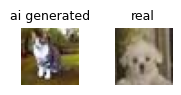

In [58]:
plt.figure(figsize=(2, 1))

plt.subplot(1, 2, 1)
plt.imshow(fake_img_pil)
plt.title(cls_fake, fontsize=9)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(real_img_pil)
plt.title(cls_real, fontsize=9)
plt.axis("off")

plt.tight_layout(pad=1.0)
plt.show()


In [59]:
print("FAKE image path:", fake_path)
print("REAL image path:", real_path)

FAKE image path: /content/datasets/cifake/train/FAKE/1688 (4).jpg
REAL image path: /content/datasets/cifake/train/REAL/0566 (6).jpg


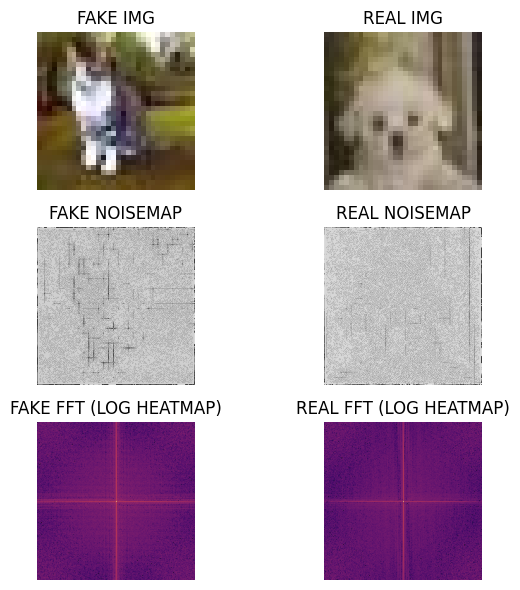

In [79]:
noise_fake = Image.open(fake_noise_path).convert("L")
noise_real = Image.open(real_noise_path).convert("L")

noise_fake_raw = np.array(noise_fake)
noise_real_raw = np.array(noise_real)

noise_fake = np.clip(noise_fake_raw * 50, 0, 255).astype(np.uint8)
noise_real = np.clip(noise_real_raw * 50, 0, 255).astype(np.uint8)

fake_fft = np.fft.fftshift(np.fft.fft2(noise_fake_raw))
real_fft = np.fft.fftshift(np.fft.fft2(noise_real_raw))

fake_fft = np.abs(fake_fft)
real_fft = np.abs(real_fft)

fake_fft_log = np.log1p(fake_fft)
real_fft_log = np.log1p(real_fft)

fake_fft_heat = fake_fft_log / fake_fft_log.max()
real_fft_heat = real_fft_log / real_fft_log.max()

plt.figure(figsize=(7,6))

plt.subplot(3, 2, 1)
plt.imshow(img_fake)
plt.title("FAKE IMG")
plt.axis("off")

plt.subplot(3, 2, 2)
plt.imshow(img_real)
plt.title("REAL IMG")
plt.axis("off")

plt.subplot(3, 2, 3)
plt.imshow(noise_fake, cmap="gray")
plt.title("FAKE NOISEMAP")
plt.axis("off")

plt.subplot(3, 2, 4)
plt.imshow(noise_real, cmap="gray")
plt.title("REAL NOISEMAP")
plt.axis("off")

plt.subplot(3, 2, 5)
plt.imshow(fake_fft_heat, cmap="inferno")
plt.title("FAKE FFT (LOG HEATMAP)")
plt.axis("off")

plt.subplot(3, 2, 6)
plt.imshow(real_fft_heat, cmap="inferno")
plt.title("REAL FFT (LOG HEATMAP)")
plt.axis("off")

plt.tight_layout()
plt.show()

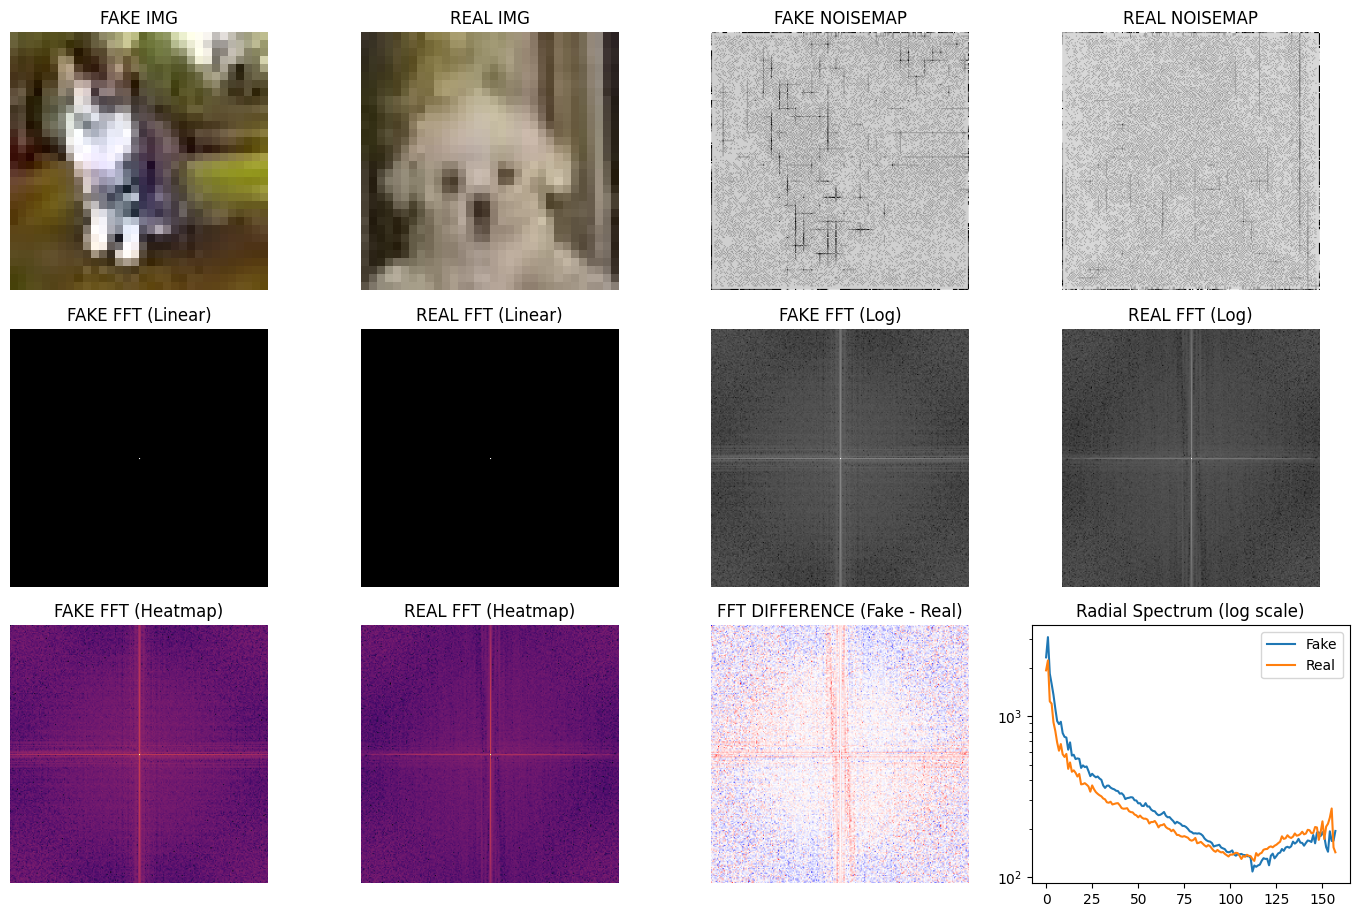

In [92]:
noise_fake_raw = np.array(Image.open(fake_noise_path).convert("L"))
noise_real_raw = np.array(Image.open(real_noise_path).convert("L"))

noise_fake_vis = np.clip(noise_fake_raw * 50, 0, 255).astype(np.uint8)
noise_real_vis = np.clip(noise_real_raw * 50, 0, 255).astype(np.uint8)

fake_fft = np.fft.fftshift(np.fft.fft2(noise_fake_raw))
real_fft = np.fft.fftshift(np.fft.fft2(noise_real_raw))

fake_fft = np.abs(fake_fft)
real_fft = np.abs(real_fft)

fake_fft_log = np.log1p(fake_fft)
real_fft_log = np.log1p(real_fft)

fake_fft_log = fake_fft_log / fake_fft_log.max()
real_fft_log = real_fft_log / real_fft_log.max()

fake_fft_heat = fake_fft_log
real_fft_heat = real_fft_log

fft_diff = fake_fft_heat - real_fft_heat

def radial_profile_no_dc(data):
    y, x = np.indices(data.shape)
    c = np.array([(x.max() - x.min())/2.0, (y.max() - y.min())/2.0])
    r = np.sqrt((x-c[0])**2 + (y-c[1])**2).astype(np.int32)

    data_no_dc = data.copy()
    data_no_dc[data_no_dc == data_no_dc.max()] = 0

    tbin = np.bincount(r.ravel(), data_no_dc.ravel())
    nr = np.bincount(r.ravel())
    return tbin / (nr + 1e-8)

fake_radial = radial_profile_no_dc(fake_fft)
real_radial = radial_profile_no_dc(real_fft)

plt.figure(figsize=(14,12))

plt.subplot(4, 4, 1)
plt.imshow(img_fake)
plt.title("FAKE IMG")
plt.axis("off")

plt.subplot(4, 4, 2)
plt.imshow(img_real)
plt.title("REAL IMG")
plt.axis("off")

plt.subplot(4, 4, 3)
plt.imshow(noise_fake_vis, cmap="gray")
plt.title("FAKE NOISEMAP")
plt.axis("off")

plt.subplot(4, 4, 4)
plt.imshow(noise_real_vis, cmap="gray")
plt.title("REAL NOISEMAP")
plt.axis("off")

plt.subplot(4, 4, 5)
plt.imshow(fake_fft, cmap="gray")
plt.title("FAKE FFT (Linear)")
plt.axis("off")

plt.subplot(4, 4, 6)
plt.imshow(real_fft, cmap="gray")
plt.title("REAL FFT (Linear)")
plt.axis("off")

plt.subplot(4, 4, 7)
plt.imshow(fake_fft_log, cmap="gray")
plt.title("FAKE FFT (Log)")
plt.axis("off")

plt.subplot(4, 4, 8)
plt.imshow(real_fft_log, cmap="gray")
plt.title("REAL FFT (Log)")
plt.axis("off")

plt.subplot(4, 4, 9)
plt.imshow(fake_fft_heat, cmap="inferno")
plt.title("FAKE FFT (Heatmap)")
plt.axis("off")

plt.subplot(4, 4, 10)
plt.imshow(real_fft_heat, cmap="inferno")
plt.title("REAL FFT (Heatmap)")
plt.axis("off")

plt.subplot(4, 4, 11)
plt.imshow(fft_diff, cmap="bwr")
plt.title("FFT DIFFERENCE (Fake - Real)")
plt.axis("off")

plt.subplot(4, 4, 12)
plt.plot(fake_radial, label="Fake")
plt.plot(real_radial, label="Real")
plt.yscale("log")
plt.title("Radial Spectrum (log scale)")
plt.legend()

plt.tight_layout()
plt.show()

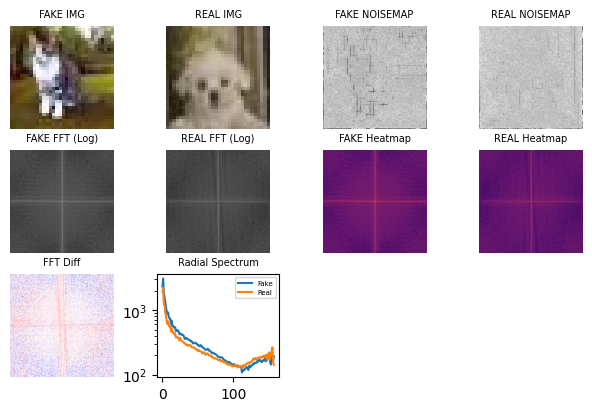

In [94]:
plt.figure(figsize=(6,4))

plt.subplot(3, 4, 1)
plt.imshow(img_fake)
plt.title("FAKE IMG", fontsize=7)
plt.axis("off")

plt.subplot(3, 4, 2)
plt.imshow(img_real)
plt.title("REAL IMG", fontsize=7)
plt.axis("off")

plt.subplot(3, 4, 3)
plt.imshow(noise_fake_vis, cmap="gray")
plt.title("FAKE NOISEMAP", fontsize=7)
plt.axis("off")

plt.subplot(3, 4, 4)
plt.imshow(noise_real_vis, cmap="gray")
plt.title("REAL NOISEMAP", fontsize=7)
plt.axis("off")

plt.subplot(3, 4, 5)
plt.imshow(fake_fft_log, cmap="gray")
plt.title("FAKE FFT (Log)", fontsize=7)
plt.axis("off")

plt.subplot(3, 4, 6)
plt.imshow(real_fft_log, cmap="gray")
plt.title("REAL FFT (Log)", fontsize=7)
plt.axis("off")

plt.subplot(3, 4, 7)
plt.imshow(fake_fft_heat, cmap="inferno")
plt.title("FAKE Heatmap", fontsize=7)
plt.axis("off")

plt.subplot(3, 4, 8)
plt.imshow(real_fft_heat, cmap="inferno")
plt.title("REAL Heatmap", fontsize=7)
plt.axis("off")

plt.subplot(3, 4, 9)
plt.imshow(fft_diff, cmap="bwr")
plt.title("FFT Diff", fontsize=7)
plt.axis("off")

plt.subplot(3, 4, 10)
plt.plot(fake_radial, label="Fake")
plt.plot(real_radial, label="Real")
plt.yscale("log")
plt.title("Radial Spectrum", fontsize=7)
plt.legend(fontsize=5)

plt.tight_layout(pad=0.3)
plt.show()